The idea with this script is that we want to use `convolve_test` to generate the merger data, then we want to be able to load that data here and make a large plot that has the all plot then the smaller populations underneath it

In [1]:
import os, copy, h5py
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
import numpy as np
import pandas as pd
from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import generate_boilerplate_outputfile, extract_unit_dict, temp_dir
from compas_python_utils.cosmic_integration.ClassCOMPAS import COMPASData
from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023, madau_dickinson_sfr
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022, compas_log_skew_normal_distribution_metallicity_distribution
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.cosmology_utils import lookback_time_to_redshift
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict
import matplotlib.pyplot as plt
from population_vis import get_formation_efficiency
import time
import warnings
import scipy
from scipy import stats
from get_ZdepSFRD import skew_metallicity_distribution
import pickle

Sum is 0.9993591035989038
Sum is 0.9995599462229728
Sum is 0.9996994245258342
Sum is 0.9997930621456227
Sum is 0.9998545081152381
Sum is 0.9997528790792566


/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_82000/3261787632.py:50: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(1e-4,0)


Sum is 0.9996220457343999
Sum is 0.9997687675656914
Sum is 0.9998466694480951
Sum is 0.9998828557144912
Sum is 0.999896796140413
Sum is 0.9998742012443079
Sum is 0.9999252411823426
Sum is 0.9998865273692845
Sum is 0.9998543290445441
Sum is 0.9998329266164756
Sum is 0.9998219564979833
Sum is 0.9998521044444776
Sum is 0.9608790319333078
Sum is 0.9618805592040379
Sum is 0.9624862880730014
Sum is 0.9627263409049821
Sum is 0.9626187040311389
Sum is 0.9620014737225947


/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_82000/3261787632.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  form_fig.show()


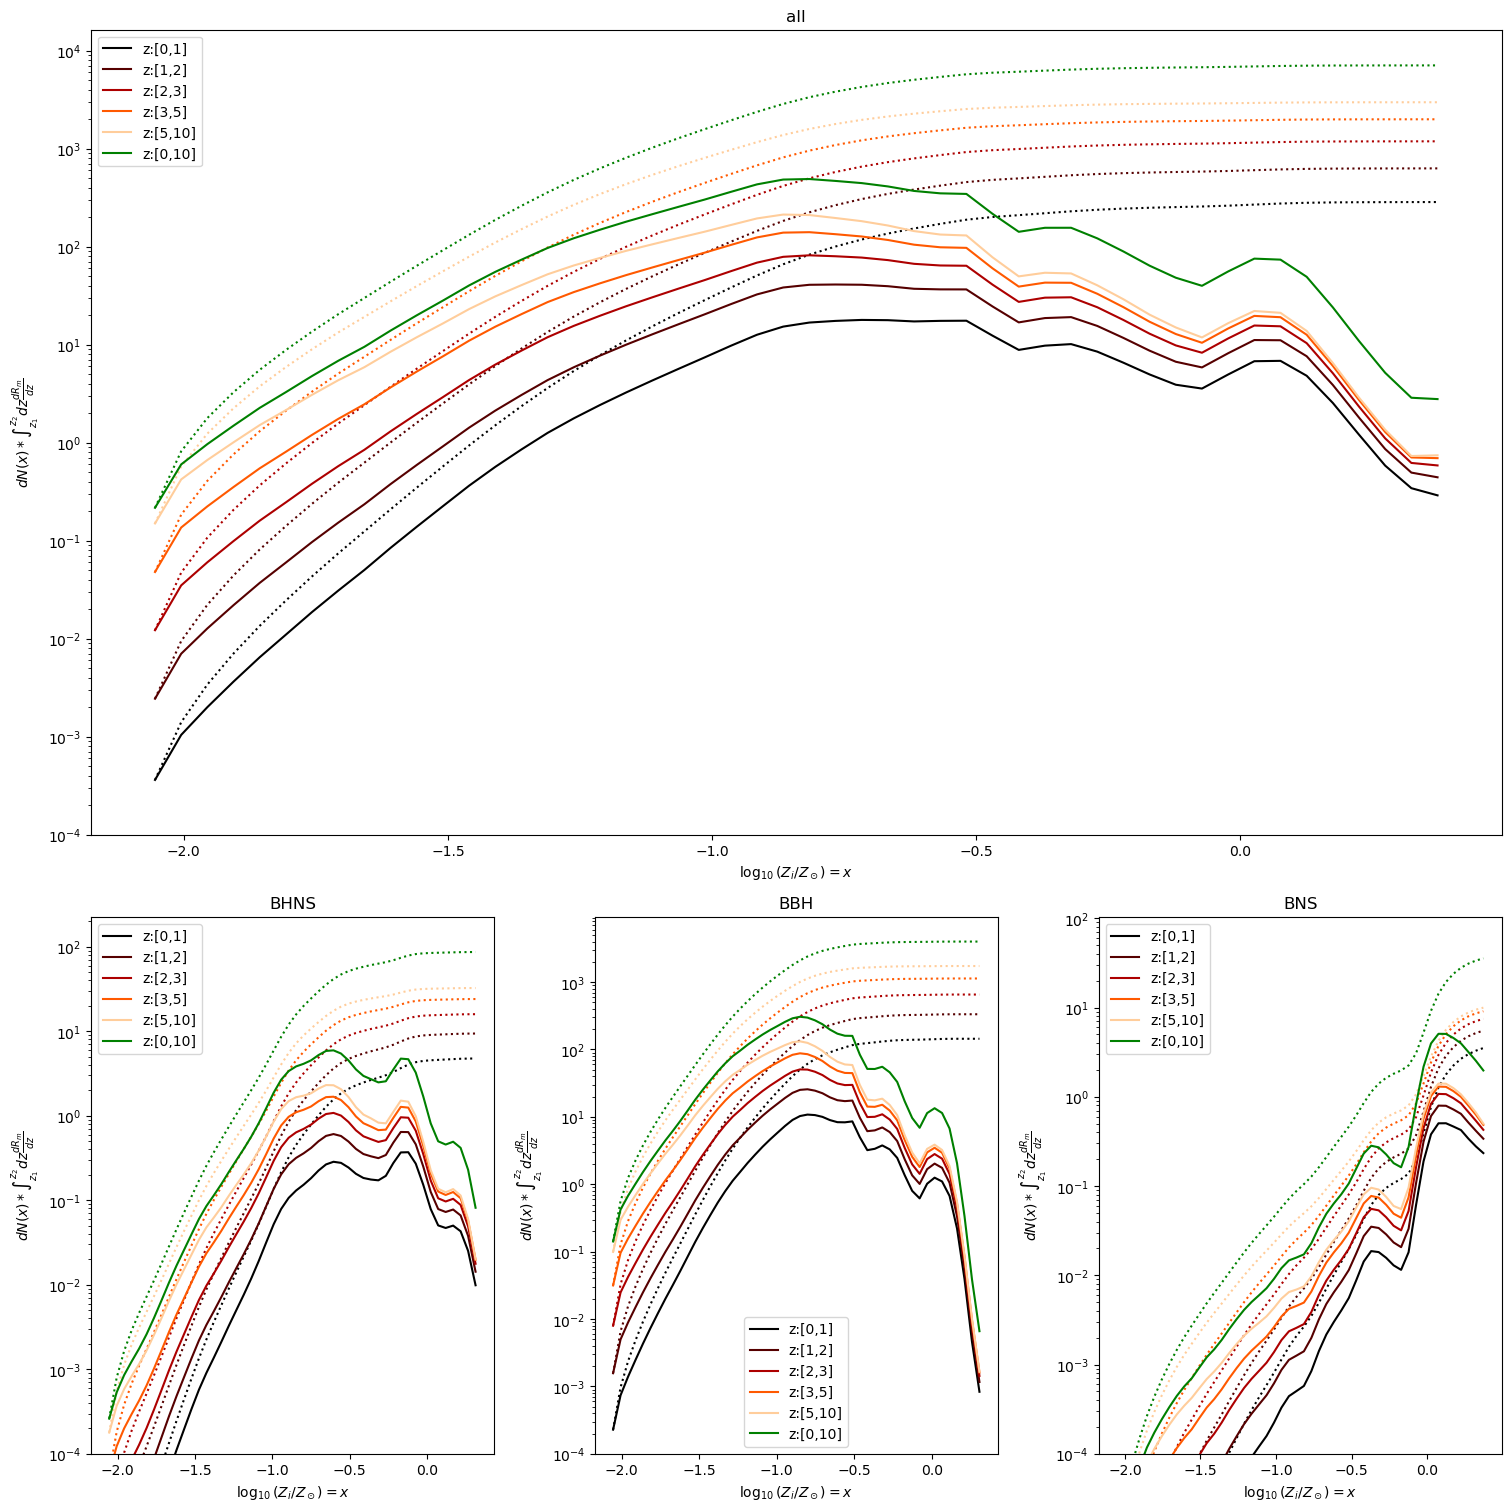

In [17]:
# basically same plot as above, but now we want to bin by redshift basically 
PLOT_Z_LOG = True

def plot(plotting_data, ax):
    all_weights = plotting_data['all_weights']
    Zm = plotting_data['Zm']
    types = plotting_data['types']

    # sum up to z
    redshift_edges = np.array([0, 1, 2, 3, 5, 10])#np.linspace(0, 14, 5)#np.logspace(np.log10(0.001), np.log10(14), 5)
    def do_metallicity_plot_to_redshift(left, right, color):
        w = np.sum(all_weights[:, (np.digitize(left, redshift_edges)-1):(np.digitize(right, redshift_edges)-1)], axis=1)
        dco_met_hist, dco_met_bins = np.histogram(
            Zm,
            weights=w,
            bins=50,
            density=True
        )
        # print(np.sum(dco_met_hist*np.diff(dco_met_bins)))

        dco_metallicity_weighted_kde = stats.gaussian_kde(
            Zm,
            weights=w # TODO: multiply weights by mixture weights?
        )

        dco_met_bins_midpoints = (dco_met_bins[:-1]+dco_met_bins[1:])/2
        dlogZ = np.diff(dco_met_bins)
        print(f'Sum is {dco_metallicity_weighted_kde(dco_met_bins_midpoints)@dlogZ}')
        plot_line = dco_metallicity_weighted_kde(dco_met_bins_midpoints)*dlogZ*np.sum(w)
        lab = f'z:[{left},{right}]'
        ax.plot(dco_met_bins_midpoints, plot_line, label=lab, color=color)
        # form_ax.fill_between(dco_met_bins_midpoints, plot_line, alpha=0.3)

        # cdf_ax = form_ax.twinx()
        # label=f'{lab} CDF'
        ax.plot(dco_met_bins_midpoints, np.cumsum(plot_line), linestyle=':', color=color)
        # cdf_ax.tick_params(axis='y', labelcolor='red')
        # cdf_ax.set_yscale('log')
        # form_ax.axhline(plot_line.max())

    color_bins = plt.cm.gist_heat(np.linspace(0, 0.9, len(redshift_edges)-1))

    for i in range(len(redshift_edges)-1):
        do_metallicity_plot_to_redshift(redshift_edges[i], redshift_edges[i+1], color_bins[i])
    do_metallicity_plot_to_redshift(0, 10, 'green')
    ax.set_xlabel(r'$\log_{10}(Z_i/Z_\odot)=x$' if PLOT_Z_LOG else r'$Z_i/Z_\odot=x$')
    ax.set_ylabel(r'$dN(x)*\int_{z_1}^{z_2} dz \frac{dR_m}{dz}$')
    ax.set_yscale('log')
    ax.set_title(types)
    ax.set_ylim(1e-4,0)
    ax.legend()

form_fig = plt.figure(constrained_layout=True, figsize=(15, 15))
form_ax = form_fig.subplot_mosaic([
    ['Top', 'Top', 'Top'],
    ['Left', 'Middle', 'Right']
], height_ratios=[3,2])

graphs = [
    {
        'fname': 'fiducial_BHNS.pkl',
        'placement': 'Left'
    },
    {
        'fname': 'fiducial_all.pkl',
        'placement': 'Top'
    },
    {
        'fname': 'fiducial_BBH.pkl',
        'placement': 'Middle'
    },
    {
        'fname': 'fiducial_BNS.pkl',
        'placement': 'Right'
    }
]

for g in graphs:
    with open(g['fname'], 'rb') as p:
        plot(pickle.load(p), form_ax[g['placement']])
    del p
form_fig.show()
# plot()
# do a plot mosaic